In [2]:
import numpy as np
import illustris_python as il
import matplotlib.pyplot as plt

In [3]:
basePath = '/orange/lblecha/IllustrisTNG/Runs/TNG50-1/output'

In [4]:
def get_scale_factors(basePath, filename="output_scale_factors.txt"):
    path = basePath.split('/output')[0]
    #print(path)
    f = open(path+"/"+filename,'r')
    snaptimes = np.array([float(line) for line in f.readlines()])
    f.close()
    print(f"snapshot scale factors in {path}:")
    print(snaptimes)
    return snaptimes

In [5]:
scale_factors_tng = get_scale_factors(basePath)

snapshot scale factors in /orange/lblecha/IllustrisTNG/Runs/TNG50-1:
[0.04751386 0.06254232 0.07704034 0.08350282 0.09093728 0.09625777
 0.09997661 0.10582597 0.11096103 0.11634526 0.12141409 0.12491542
 0.13348287 0.14263794 0.1460576  0.15314485 0.16057599 0.1667797
 0.17653754 0.18422877 0.19316822 0.1996827  0.21236949 0.22267443
 0.2334794  0.24949284 0.25668768 0.26787083 0.2795412  0.29034102
 0.30155808 0.31172794 0.32224077 0.33310814 0.344342   0.35427208
 0.36448853 0.37499959 0.38398999 0.39506344 0.40071935 0.41423335
 0.42416436 0.43433346 0.44474635 0.45325613 0.46412269 0.47300321
 0.48205365 0.49127726 0.50067736 0.51268081 0.52002058 0.52997065
 0.54011111 0.55044559 0.55832602 0.56900902 0.57715521 0.5881985
 0.59661941 0.60803512 0.61674002 0.62556955 0.63452548 0.64666649
 0.65592445 0.66531496 0.6748399  0.68450121 0.69430083 0.70424076
 0.71432298 0.72454955 0.73492252 0.74192021 0.75254187 0.76331559
 0.77058363 0.78532797 0.7928056  0.80415576 0.81566841 0.8234

## Reading from the Group and Subhalo Catalog

The number of subhalos in snapshot 1 is 689643


Text(0, 0.5, 'Star Formation Rate [$M_\\odot / yr$]')

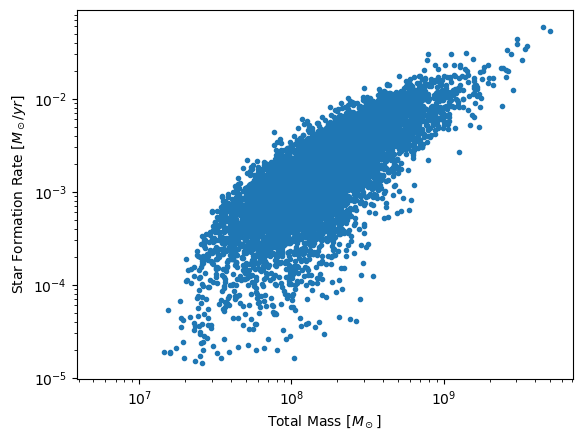

In [6]:
#groupcat.loadSubhalos() loads the subhalo data from the group catalog
#The group catalog is a collection of all the subhalos in a given snapshot

fields = ['SubhaloMass','SubhaloSFRinRad']
snapnumber = 1
subhalos = il.groupcat.loadSubhalos(basePath,snapnumber,fields=fields)
print("The number of subhalos in snapshot %d is %d"%(snapnumber,subhalos['count']))

h = il.groupcat.loadHeader(basePath,snapnumber)['HubbleParam']
Subhalomass = subhalos['SubhaloMass'] * 1e10 / h

plt.plot(Subhalomass,subhalos['SubhaloSFRinRad'],'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Mass [$M_\odot$]')
plt.ylabel('Star Formation Rate [$M_\odot / yr$]')

In [7]:
#loading the primary subhalo IDs
Groupinfo = il.groupcat.loadHalos(basePath,snapnumber,fields=['GroupFirstSub','GroupBHMass','GroupNsubs'])
print("The number of FoF groups/halos in snapshot %d is %d"%(snapnumber,Groupinfo['count']))
print("The number of FoF groups/halos with atleast one subhalo is %d"%(np.sum(Groupinfo['GroupNsubs'] > 0)))

The number of FoF groups/halos in snapshot 1 is 756234
The number of FoF groups/halos with atleast one subhalo is 667139


In [8]:
## loading the  5 most massive central subhalos and printing their gas fraction
ptNumGas = il.snapshot.partTypeNum('gas') # 0
ptNumStars = il.snapshot.partTypeNum('stars') # 4

for i in range(5):
    all_fields = il.groupcat.loadSingle(basePath,1,subhaloID=Groupinfo['GroupFirstSub'][i])
    gas_mass   = all_fields['SubhaloMassInHalfRadType'][ptNumGas]
    stars_mass = all_fields['SubhaloMassInHalfRadType'][ptNumStars]
    frac = gas_mass / (gas_mass + stars_mass)
    print("FoF ID: %d, Primary Subhalo ID: %d, Gas fraction: %.2f" % (Groupinfo['GroupFirstSub'][i], Groupinfo['GroupFirstSub'][i], frac))

FoF ID: 0, Primary Subhalo ID: 0, Gas fraction: 0.97
FoF ID: 24, Primary Subhalo ID: 24, Gas fraction: 0.94
FoF ID: 35, Primary Subhalo ID: 35, Gas fraction: 0.96
FoF ID: 50, Primary Subhalo ID: 50, Gas fraction: 0.96
FoF ID: 79, Primary Subhalo ID: 79, Gas fraction: 0.96


In [9]:
subhalos = il.groupcat.loadSubhalos(basePath, snapNum=1, fields=['SubhaloMass', 'SubhaloGrNr'])

# Get the "index-based IDs" for subhalos (0 to N-1)
subhalo_indices = np.arange(len(subhalos['SubhaloMass']))

halo_data = il.groupcat.loadHalos(basePath, snapNum=1, fields=['GroupFirstSub', 'GroupNsubs'])
group_first_sub = halo_data['GroupFirstSub']  # Index of first subhalo in subhalo catalog
group_nsubs = halo_data['GroupNsubs']         # Number of subhalos in halo

def subhalo_indices_in_halo(halo_index):
    """
    Get the indices of subhalos in a given halo.
    """
    start = group_first_sub[halo_index]
    end = start + group_nsubs[halo_index]
    print("Subhalo indices in halo %d: %d to %d" % (halo_index, start, end))

    return subhalo_indices[start:end]


subixs = subhalo_indices_in_halo(1)

Subhalo indices in halo 1: 24 to 35


So the subhalo index is essentially the ordered array of subhalos. GroupFirstSub corresponds to the the primary subhalo's ID in each halo. GroupNsubs shows the number of subhalos within each halos.

## Sublink Merger Tree

In [10]:
group_first_sub[10]

158

The SubLink algorithm constructs merger trees at the subhalo level. A unique descendant is assigned to each subhalo in three steps (see Rodriguez-Gomez+ 2015). First, descendant candidates are identified for each subhalo as those subhalos in the following snapshot that have common particles with the subhalo in question. Second, each of the descendant candidates is given a score based on a merit function that takes into account the binding energy rank of each particle. Third, the unique descendant of the subhalo in question is the descendant candidate with the highest score. Sometimes the halo finder does not detect a small subhalo that is passing through a larger structure, because the density contrast is not high enough. {\sc SubLink} deals with this issue by allowing some subhalos to skip a snapshot when finding a descendant. Once all descendant connections have been made, the main progenitor of each subhalo is defined as the one with the "most massive history" behind it.

In [11]:
fields = ['SubhaloID','LastProgenitorID','MainLeafProgenitorID','RootDescendantID','TreeID','FirstProgenitorID','NextProgenitorID','DescendantID','SubhaloMass','SubhaloMassType','SubfindID','SnapNum','FirstSubhaloInFOFGroupID']
tree = il.sublink.loadTree(basePath,99,group_first_sub[0],fields=fields,onlyMPB=False)

In [12]:
tree['SubhaloID'].size

10071090

In [13]:
def print_tree_details(tree, index):
    """
    Print details of a specific subhalo in the tree.
    """
    print("Subhalo ID:", tree['SubhaloID'][index])
    print("Main Leaf Progenitor ID:", tree['MainLeafProgenitorID'][index])
    print("First Progenitor ID:", tree['FirstProgenitorID'][index])
    print("Next Progenitor ID:", tree['NextProgenitorID'][index])
    print("Descendant ID:", tree['DescendantID'][index])
    print("SnapNum:", tree['SnapNum'][index])
    print("FOF Group ID:", tree['FirstSubhaloInFOFGroupID'][index])

    Progenitor_tree_length = tree['MainLeafProgenitorID'][index]-tree['SubhaloID'][index]+1
    print("Progenitor tree length:", Progenitor_tree_length)

    Main_progenitor_index = index+tree['MainLeafProgenitorID'][index]-tree['SubhaloID'][index]
    print("Main progenitor index:", Main_progenitor_index)

In [14]:
print_tree_details(tree,100)

Subhalo ID: 90497340
Main Leaf Progenitor ID: 90497340
First Progenitor ID: -1
Next Progenitor ID: 90497341
Descendant ID: 90497338
SnapNum: 0
FOF Group ID: 90497340
Progenitor tree length: 1
Main progenitor index: 100


In [15]:
basePath

'/orange/lblecha/IllustrisTNG/Runs/TNG50-1/output'

In [16]:
snapNum=99
sub_lentype = il.groupcat.loadSubhalos(basePath, snapNum, fields=['SubhaloLenType'])

minNgas = 100
minNdm = 100
minNstar = 100
minNbh = 1

Ngas = sub_lentype[:,0]
Ndm = sub_lentype[:,1]
Nstar = sub_lentype[:,4]
Nbh = sub_lentype[:,5]
idx = np.where((Ngas >= minNgas) & (Ndm >= minNdm) & (Nstar >= minNstar) & (Nbh >= minNbh))[0]

In [17]:
fields = ['SubhaloID', 'NextProgenitorID', 'MainLeafProgenitorID', 'FirstProgenitorID',
              'LastProgenitorID', 'RootDescendantID', 'SubhaloLenType', 'SubhaloMassType',
              'SnapNum', 'DescendantID', 'SubfindID','FirstSubhaloInFOFGroupID']

In [18]:
minMassRatio=1e-10
invMinMassRatio = 1.0 / minMassRatio
index = 0
count = 0

k=0
isub=1
tree = il.sublink.loadTree(basePath, snapNum, isub, fields=fields, onlyMPB=False)

In [19]:
def getMergerInfoSubtree(tree, index, minMassRatio, invMinMassRatio):
    rootID = tree['SubhaloID'][index]
    fpID = tree['FirstProgenitorID'][index]
    rootSnap = tree['SnapNum'][index]
    fpSnap = rootSnap #tree['SnapNum'][index]
    fdesID = tree['DescendantID'][index]

    # Define the dictionaries first
    fp_info = {'SnapNum': [], 'SubhaloID': [], 'SubfindID': [], 'Index': []}
    np_info = {'SnapNum': [], 'SubhaloID': [], 'SubfindID': [], 'Index': []}
    desc_info = {'SnapNum': [], 'SubhaloID': [], 'SubfindID': [], 'Index': []}

    counter = 0  # Initialize a counter

    while fpID != -1:
        fpIndex = index + (fpID - rootID)
        fpMass  = il.sublink.maxPastMass(tree, fpIndex)
        fpNpart = tree['SubhaloLenType'][fpIndex,:]

        npID = tree['NextProgenitorID'][fpIndex]
        npSnap = tree['SnapNum'][fpIndex]
        ndesID = tree['DescendantID'][fpIndex]

        fdesIndex = index + (fdesID - rootID)

        while npID != -1:
            npIndex = index + (npID - rootID)
            npMass  = il.sublink.maxPastMass(tree, npIndex)
            npNpart = tree['SubhaloLenType'][npIndex,:]

            ndesIndex = index + (ndesID - rootID)

            if fpMass > 0.0 and npMass > 0.0:
                ratio = npMass / fpMass

                if (ratio >= minMassRatio and ratio <= invMinMassRatio and
                    min(npNpart[0], fpNpart[0]) >= minNgas and 
                    min(npNpart[1], fpNpart[1]) >= minNdm and
                    min(npNpart[4], fpNpart[4]) >= minNstar and
                    min(npNpart[5], fpNpart[5]) >= minNbh):

                    counter += 1  #count the mergers

                    if fpSnap == (npSnap+2):
                        print(f"NOTE: SubLink skipped snap {npSnap+1} in finding descendant.")

                    elif fpSnap != (npSnap+1) and fpSnap != (npSnap+2):
                            raise Exception(f'ERROR: snaps not contiguous b/t prog ({npSnap}) & desc ({fpSnap}).')
                    
                    print(fpSnap,npSnap,tree['SnapNum'][ndesIndex],tree['SnapNum'][fpIndex],tree['SnapNum'][npIndex])

                    fp_info['SnapNum'].append(tree['SnapNum'][fpIndex])
                    fp_info['SubhaloID'].append(tree['SubhaloID'][fpIndex])
                    fp_info['SubfindID'].append(tree['SubfindID'][fpIndex])
                    fp_info['Index'].append(fpIndex)

                    np_info['SnapNum'].append(tree['SnapNum'][npIndex])
                    np_info['SubhaloID'].append(tree['SubhaloID'][npIndex])
                    np_info['SubfindID'].append(tree['SubfindID'][npIndex])
                    np_info['Index'].append(npIndex)

                    desc_info['SnapNum'].append(tree['SnapNum'][ndesIndex])
                    desc_info['SubhaloID'].append(tree['SubhaloID'][ndesIndex])
                    desc_info['SubfindID'].append(tree['SubfindID'][ndesIndex])
                    desc_info['Index'].append(ndesIndex)

            npID = tree['NextProgenitorID'][npIndex]
            npSnap = tree['SnapNum'][npIndex]
            ndesID = tree['DescendantID'][npIndex]

        fpID = tree['FirstProgenitorID'][fpIndex]
        fpSnap = tree['SnapNum'][fpIndex]
        fdesID = tree['DescendantID'][fpIndex]

    return counter, fp_info, np_info, desc_info

In [20]:
count,fp_info,np_info,desc_info = getMergerInfoSubtree(tree, 0, minMassRatio, invMinMassRatio)

37 36 37 36 36
27 26 27 26 26
24 23 24 23 23


In [21]:
def check_fof_groups_of_progenitors_all():
    mismatches = []
    for n, isub in enumerate(idx):
        print(f"Processing {n+1}th subhalo out of {len(idx)}")
        
        tree = il.sublink.loadTree(basePath, snapNum, isub, fields=fields, onlyMPB=False)
        if tree is None:
            continue
        count, fp_info, np_info, desc_info = getMergerInfoSubtree(tree, 0, minMassRatio, invMinMassRatio)
        for fp_idx, np_idx,desc_idx in zip(fp_info['Index'], np_info['Index'],desc_info['Index']):
            fp_fof = tree['FirstSubhaloInFOFGroupID'][fp_idx]
            np_fof = tree['FirstSubhaloInFOFGroupID'][np_idx]

            if fp_fof != np_fof:
                # Store the mismatch details: isub, fp_idx, np_idx, and optionally tree details
                mismatch_detail = {
                    'isub': isub,
                    'fp_idx': fp_idx,
                    'np_idx': np_idx,
                    'fp_fof': fp_fof,
                    'np_fof': np_fof,
                    'fp_snapnum': tree['SnapNum'][fp_idx],
                    'np_snapnum': tree['SnapNum'][np_idx],
                    'desc_snapnum': tree['SnapNum'][desc_idx],
                }
                mismatches.append(mismatch_detail)
                print(f"Mismatch at isub={isub}, fp_idx={fp_idx}, np_idx={np_idx}: fp_fof={fp_fof}, np_fof={np_fof}, fp_snapnum={tree['SnapNum'][fp_idx]}, np_snapnum={tree['SnapNum'][np_idx]}, desc_snapnum={tree['SnapNum'][desc_idx]}")
                
    return mismatches

In [22]:
FOF_Mismatches = check_fof_groups_of_progenitors_all()

Processing 1th subhalo out of 3734
32 31 32 31 31
22 21 22 21 21
Processing 2th subhalo out of 3734
37 36 37 36 36
27 26 27 26 26
24 23 24 23 23
Processing 3th subhalo out of 3734
33 32 33 32 32
Processing 4th subhalo out of 3734
Processing 5th subhalo out of 3734
Processing 6th subhalo out of 3734
NOTE: SubLink skipped snap 22 in finding descendant.
23 21 23 21 22
Mismatch at isub=7, fp_idx=77, np_idx=3894: fp_fof=101207836, np_fof=101211653, fp_snapnum=21, np_snapnum=22, desc_snapnum=23
Processing 7th subhalo out of 3734
Processing 8th subhalo out of 3734
Processing 9th subhalo out of 3734
35 34 35 34 34
Processing 10th subhalo out of 3734
46 45 46 45 45
Processing 11th subhalo out of 3734
Processing 12th subhalo out of 3734
Processing 13th subhalo out of 3734
Processing 14th subhalo out of 3734
Processing 15th subhalo out of 3734
Processing 16th subhalo out of 3734
Processing 17th subhalo out of 3734
Processing 18th subhalo out of 3734
Processing 19th subhalo out of 3734
Processing 

In [57]:
def find_infall_and_maxpastmass(tree, fp_index, np_index):

    fp_mpb_size = tree['MainLeafProgenitorID'][fp_index] - tree['SubhaloID'][fp_index] + 1
    np_mpb_size = tree['MainLeafProgenitorID'][np_index] - tree['SubhaloID'][np_index] + 1

    first_subs_fp = tree['FirstSubhaloInFOFGroupID'][fp_index: fp_index + fp_mpb_size]
    first_subs_np = tree['FirstSubhaloInFOFGroupID'][np_index: np_index + np_mpb_size]

    print(first_subs_fp)
    print(first_subs_np)

    fp_masses = tree['SubhaloMassType'][fp_index: fp_index + fp_mpb_size , 4]
    np_masses = tree['SubhaloMassType'][np_index: np_index + np_mpb_size , 4]

    fp_snapshpot_num = tree['SnapNum'][fp_index: fp_index + fp_mpb_size]
    np_snapshpot_num = tree['SnapNum'][np_index: np_index + np_mpb_size]


    first_mismatch = None

    if first_subs_fp[0] == first_subs_np[0]:
        for i, (a, b) in enumerate(zip(first_subs_fp[0:], first_subs_np[0:])):
            if a != b:
                first_mismatch = i
                break
    else:
        if first_subs_np[0]==first_subs_fp[1]:
            print("np snap > fp snap")
            for i, (a, b) in enumerate(zip(first_subs_fp[1:], first_subs_np[0:])):
                if a != b:
                    print(f"Mismatch at index {i}: {a} != {b}")
                    first_mismatch = i
                    break
            print(first_subs_fp[first_mismatch],np_masses[first_mismatch-1])
            fp_infall_mass = fp_masses[first_mismatch]
            np_infall_mass = np_masses[first_mismatch-1]
        else:
            print("fp snap > np snap")
            for i, (a, b) in enumerate(zip(first_subs_fp[0:], first_subs_np[1:])):
                if a != b:
                    print(f"Mismatch at index {i}: {a} != {b}")
                    first_mismatch = i
                    break
            print(first_subs_fp[first_mismatch-1],np_masses[first_mismatch])
            fp_infall_mass = fp_masses[first_mismatch-1]
            np_infall_mass = np_masses[first_mismatch]

    #past_max_mass_index = np.argwhere(np_masses == np.max(np_masses))[0][0]
    fp_past_max_mass = np.max(fp_masses)
    np_past_max_mass = np.max(np_masses)
    
    return fp_past_max_mass,np_past_max_mass,fp_infall_mass,np_infall_mass,fp_masses, np_masses, fp_snapshpot_num, np_snapshpot_num

# Example usage:
# first_mismatch = find_first_mismatch(tree, fp_index=60, np_index=550446)

In [58]:
FOF_Mismatches[7]

{'isub': 229933,
 'fp_idx': 83,
 'np_idx': 2469,
 'fp_fof': 186365121,
 'np_fof': 186367507,
 'fp_snapnum': 16,
 'np_snapnum': 15,
 'desc_snapnum': 17}

In [59]:
FOF_Mismatches[1]

{'isub': 143883,
 'fp_idx': 64,
 'np_idx': 54867,
 'fp_fof': 37238767,
 'np_fof': 37238768,
 'fp_snapnum': 35,
 'np_snapnum': 34,
 'desc_snapnum': 36}

In [60]:
i=1
tree = il.sublink.loadTree(basePath, snapNum,FOF_Mismatches[i]['isub'], fields=fields, onlyMPB=False)
find_infall_and_maxpastmass(tree, FOF_Mismatches[i]['fp_idx'],FOF_Mismatches[i]['np_idx'])


[37238767 37238768 37238769 37238770 37238771 37238772 37238773 37238774
 37238775 37238776 37238777 37238778 37238779 37238780 37238781 37238782
 37238783 37246753 37246754 37246755 37246756 37246757 37246758 37238790
 37238791 37238792 37238793 37238794 37238795 37238796 37238797 37238840
 37238799 37238842 37238801 37238802]
[37238768 37238769 37238770 37238771 37314745 37314746 37314747 37314748
 37314749 37314750 37293580 37293581 37293582 37293583 37293584 37293585
 37293586 37293587 37293588 37293589 37293590 37293591 37293592 37293593
 37293594 37293595 37293596 37293597 37293598 37293599 37293618 37293601
 37293602 37293603 37293604]
np snap > fp snap
Mismatch at index 4: 37238772 != 37314745
37238771 0.0040480983


(4.994693,
 0.107786655,
 3.8880212,
 0.0040480983,
 array([4.9946928e+00, 4.4226079e+00, 4.1122999e+00, 3.9237525e+00,
        3.8880212e+00, 3.7719612e+00, 3.5849607e+00, 3.3622303e+00,
        3.0173531e+00, 2.3229589e+00, 2.0057616e+00, 1.4648926e+00,
        1.2674919e+00, 1.1239477e+00, 9.2204273e-01, 7.2805268e-01,
        3.0919376e-01, 9.6114196e-02, 2.7029200e-02, 1.6327422e-03,
        3.1178449e-03, 2.0442088e-03, 1.8797064e-03, 1.3320305e-03,
        1.0047740e-03, 8.2939322e-04, 6.3007552e-04, 5.6397932e-04,
        3.0561662e-04, 1.6025489e-04, 6.1257175e-05, 2.2557777e-05,
        4.7360270e-05, 1.3046710e-05, 4.9648438e-06, 0.0000000e+00],
       dtype=float32),
 array([1.07199796e-01, 1.07786655e-01, 5.01889875e-03, 4.04809834e-03,
        3.29184271e-02, 2.54989434e-02, 3.43531556e-02, 1.89592000e-02,
        1.69785824e-02, 1.32734170e-02, 8.79438967e-03, 6.78067701e-03,
        5.04136877e-03, 3.89359682e-03, 3.01884883e-03, 1.91525987e-03,
        1.52831711e-03, 

In [108]:
for i in range(len(FOF_Mismatches)):
    tree = il.sublink.loadTree(basePath, snapNum,FOF_Mismatches[i]['isub'], fields=fields, onlyMPB=False)
    infall_mass_index,past_max_mass_index, fp_masses, np_masses, fp_snapshpot_num, np_snapshpot_num = find_infall_and_maxpastmass(tree, FOF_Mismatches[i]['fp_idx'],FOF_Mismatches[i]['np_idx'])

    fp_infall_mass_index = infall_mass_index-1
    np_infall_mass_index = infall_mass_index

    if(infall_mass_index == 0):
        print(i,fp_infall_mass_index, np_infall_mass_index)
        fp_infall_mass_index = 0
        np_infall_mass_index = 0

[101207836 101207837 101207838 101207839 101207840 101207841 101207842
 101207843 101207844 101207845 101207846 101207847 101207848 101207849
 101207850 101207851 101207852 101207853 101207854 101207949 101207856]
[101211653 101207836 101207837 101207838 101211657 101211658 101211659
 101211660 101211661 101211662 101211663 101211664 101211665 101211666
 101211667 101211668 101211669 101211670 101211671 101211672 101211673
 101211674]
Mismatch at index 0: 101207837 != 101211653
0 -1 0
[37238767 37238768 37238769 37238770 37238771 37238772 37238773 37238774
 37238775 37238776 37238777 37238778 37238779 37238780 37238781 37238782
 37238783 37246753 37246754 37246755 37246756 37246757 37246758 37238790
 37238791 37238792 37238793 37238794 37238795 37238796 37238797 37238840
 37238799 37238842 37238801 37238802]
[37238768 37238769 37238770 37238771 37314745 37314746 37314747 37314748
 37314749 37314750 37293580 37293581 37293582 37293583 37293584 37293585
 37293586 37293587 37293588 372935

In [88]:
infall_mass_index,past_max_mass_index, fp_masses, np_masses, fp_snapshpot_num, np_snapshpot_num = find_infall_and_maxpastmass(tree, FOF_Mismatches[2]['fp_idx'],FOF_Mismatches[2]['np_idx'])

Mismatch at index 26: 38375451 != 38382612


In [70]:
one_plus_z = 1.0 / scale_factors_tng

In [84]:
def plot_infall_and_maxmass(i):
    tree = il.sublink.loadTree(basePath, snapNum,FOF_Mismatches[i]['isub'], fields=fields, onlyMPB=False)
    infall_idx,past_mass_idx,fp_mass,np_mass,fp_snaps,np_snaps = find_infall_and_maxpastmass(tree,FOF_Mismatches[i]['fp_idx'],FOF_Mismatches[i]['np_idx'])

    print("Max past mass of FP:",fp_mass[past_mass_idx]* 10**10 / h)
    print("Max past mass of NP:",np_mass[past_mass_idx]* 10**10 / h)
    past_mass_ratio = np_mass[past_mass_idx] / fp_mass[past_mass_idx]
    if past_mass_ratio > 1:
        past_mass_ratio = 1.0 / past_mass_ratio
    print("Past mass ratio:", past_mass_ratio)
    print("Infall mass of FP:",fp_mass[infall_idx-1]* 10**10 / h)
    print("Infall mass of NP:",np_mass[infall_idx]* 10**10 / h)
    print("Infall mass ratio:",np_mass[infall_idx]/fp_mass[infall_idx-1])

    plt.plot(one_plus_z[fp_snaps], fp_mass * 10**10 / h)
    plt.plot(one_plus_z[np_snaps], np_mass * 10**10 / h)
    plt.axvline(x=one_plus_z[np_snaps[infall_idx]], color='black', linestyle='--', label='Infall Time')
    plt.axvline(x=one_plus_z[np_snaps[past_mass_idx]], 
                color='blue', linestyle='-.', label='Max past mass')
    plt.legend()
    plt.yscale('log',base=10)
    plt.xlabel('1+z')
    plt.ylabel('$M_{\star}$[$M_\odot$]')
    plt.xlim(1,4)

[37238744 38396927 38396928 37238747 37238748 38396931 38382592 38396933
 38396934 38382595 38382596 38382597 38382598 38396939 38382600 38382601
 38396942 38396943 38396944 38396945 38396946 38382607 38382608 38382609
 38382610 38382611 38375451 38375452 38375453 38375454 38375455 38375456
 38375457 38377260 38377261 38377263 38375461 38375462 38375463 38375464
 38375465 38375466 38375467 38375468 38375469 38375470 38375471 38375472
 38375579 38375580 38375543 38375476 38375477 38375478 38375479 38375480]
[38396925 37238744 38396927 38396928 37238747 37238748 38396931 38382592
 38396933 38396934 38382595 38382596 38382597 38382598 38396939 38382600
 38382601 38396942 38396943 38396944 38396945 38396946 38382607 38382608
 38382609 38382610 38382611 38382612 38382613 38382614 38382615 38382616
 38382617 38382618 38382619 38382620 38382621 38382622 38382623 38382624
 38382625 38382626 38382627 38382628 38382629 38382630 38382631 38382632
 38382633 38382634 38382635 38382636 38382637 3838

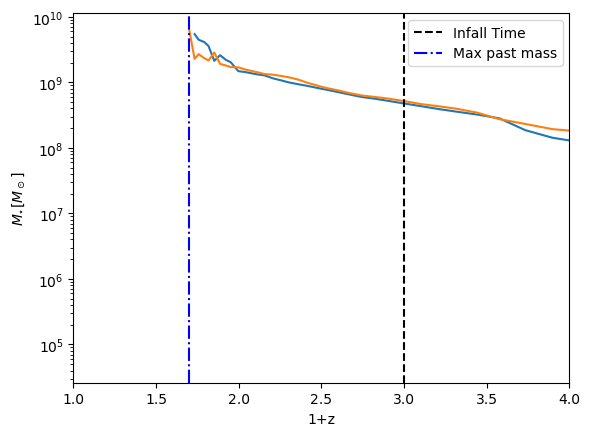

In [85]:
plot_infall_and_maxmass(2)


In [29]:
tree = il.sublink.loadTree(basePath, snapNum,FOF_Mismatches[2]['isub'], fields=fields, onlyMPB=False)
infall_idx,past_mass_idx,fp_mass,np_mass,fp_snaps,np_snaps = find_infall_and_maxpastmass(tree,FOF_Mismatches[2]['fp_idx'],FOF_Mismatches[2]['np_idx'])

print("Max past mass of FP:",fp_mass[past_mass_idx]* 10**10 / h)
print("Max past mass of NP:",np_mass[past_mass_idx]* 10**10 / h)
print("Past mass ratio:",np_mass[past_mass_idx]/fp_mass[past_mass_idx])
print("Infall mass of FP:",fp_mass[infall_idx]* 10**10 / h)
print("Infall mass of NP:",np_mass[infall_idx]* 10**10 / h)
print("Infall mass ratio:",np_mass[infall_idx]/fp_mass[infall_idx])

Max past mass of FP: 5457307653.931132
Max past mass of NP: 6323497151.779431
Past mass ratio: 1.1587211
Infall mass of FP: 5457307653.931132
Infall mass of NP: 6323497151.779431
Infall mass ratio: 1.1587211


In [30]:
one_plus_z = 1.0 / scale_factors_tng

(0.0, 4.0)

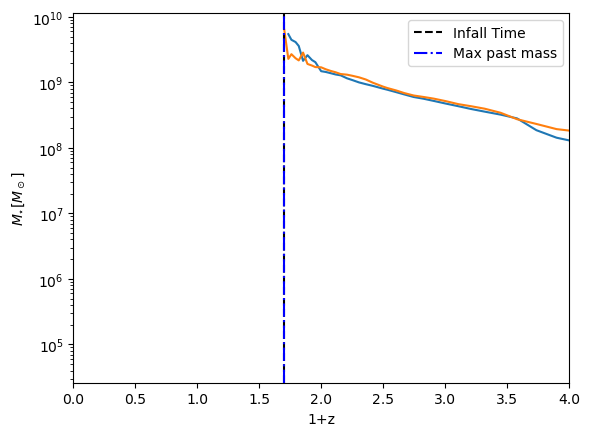

In [31]:
plt.plot(one_plus_z[fp_snaps], fp_mass * 10**10 / h)
plt.plot(one_plus_z[np_snaps], np_mass * 10**10 / h)
plt.axvline(x=one_plus_z[np_snaps[infall_idx]], color='black', linestyle='--', label='Infall Time')
plt.axvline(x=one_plus_z[np_snaps[past_mass_idx]], 
            color='blue', linestyle='-.', label='Max past mass')
plt.legend()
plt.yscale('log',base=10)
plt.xlabel('1+z')
plt.ylabel('$M_{\star}$[$M_\odot$]')
plt.xlim(0,4)

In [32]:
past_mass_idx

0

In [30]:
fp_mpb_size = tree['MainLeafProgenitorID'][FOF_Mismatches[1]['fp_idx']] - tree['SubhaloID'][FOF_Mismatches[1]['fp_idx']] + 1
first_subs_fp = tree['FirstSubhaloInFOFGroupID'][FOF_Mismatches[1]['fp_idx']:FOF_Mismatches[1]['fp_idx']+fp_mpb_size]

In [29]:
np_mpb_size = tree['MainLeafProgenitorID'][FOF_Mismatches[1]['np_idx']] - tree['SubhaloID'][FOF_Mismatches[1]['np_idx']] + 1

first_subs_np = tree['FirstSubhaloInFOFGroupID'][FOF_Mismatches[1]['np_idx']:FOF_Mismatches[1]['np_idx']+np_mpb_size]

In [31]:
first_subs_fp[0], first_subs_np[0]

(37238767, 37238768)

In [38]:
for i, (a, b) in enumerate(zip(first_subs_np, first_subs_fp[1:])):
    if a != b:
        mismatch_index=i
        print(f"Mismatch at index {i}: {a} != {b}")
        break


Mismatch at index 4: 37314745 != 37238772


In [25]:
tree = il.sublink.loadTree(basePath,snapNum,143883, fields=fields, onlyMPB=False)

tree_mrgr_count,tree_fp,tree_np,tree_desc = getMergerInfoSubtree(tree, index, minMassRatio, invMinMassRatio)

39 38 39 38 38
36 35 36 35 34


In [102]:
il.sublink.numMergers(tree,index=0)

8314

In [19]:
one_plus_z = 1.0 / scale_factors_tng

First mismatch at index 1: np=90497301, fp=90497300


Text(0, 0.5, '$M_{\\star}$[$M_\\odot$]')

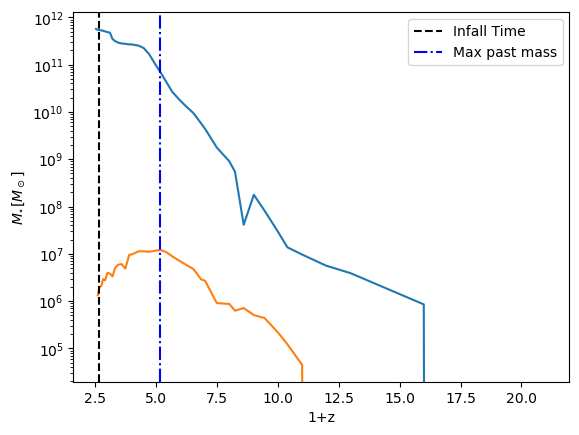

In [20]:
infall_idx,past_mass_idx,fp_mass,np_mass,fp_snaps,np_snaps = find_infall_and_maxpastmass(tree, fp_index=60, np_index=549828)

plt.plot(one_plus_z[fp_snaps], fp_mass * 10**10 / h)
plt.plot(one_plus_z[np_snaps], np_mass * 10**10 / h)
plt.axvline(x=one_plus_z[np_snaps[infall_idx]], color='black', linestyle='--', label='Infall Time')
plt.axvline(x=one_plus_z[np_snaps[past_mass_idx]], 
            color='blue', linestyle='-.', label='Max past mass')
plt.legend()
plt.yscale('log',base=10)
plt.xlabel('1+z')
plt.ylabel('$M_{\star}$[$M_\odot$]')

First mismatch at index 11: np=90497311, fp=90497310


Text(0, 0.5, '$M_{\\star}$[$M_\\odot$]')

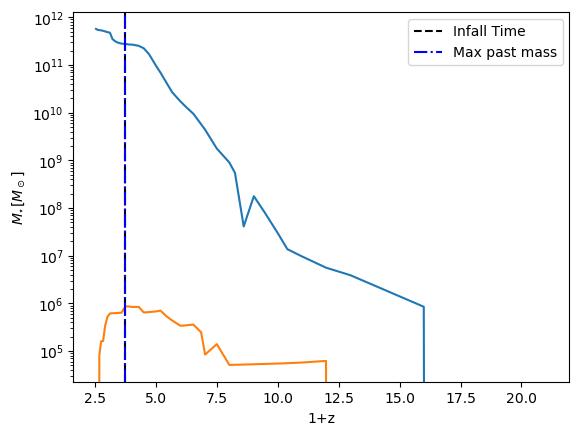

In [21]:
infall_idx,past_mass_idx,fp_mass,np_mass,fp_snaps,np_snaps = find_infall_and_maxpastmass(tree, fp_index=60, np_index=549985)

plt.plot(one_plus_z[fp_snaps], fp_mass * 10**10 / h)
plt.plot(one_plus_z[np_snaps], np_mass * 10**10 / h)
plt.axvline(x=one_plus_z[np_snaps[infall_idx]], color='black', linestyle='--', label='Infall Time')
plt.axvline(x=one_plus_z[np_snaps[past_mass_idx]], 
            color='blue', linestyle='-.', label='Max past mass')
plt.legend()
plt.yscale('log',base=10)
plt.xlabel('1+z')
plt.ylabel('$M_{\star}$[$M_\odot$]')

First mismatch at index 16: np=94476762, fp=90497315


Text(0, 0.5, '$M_{\\star}$[$M_\\odot$]')

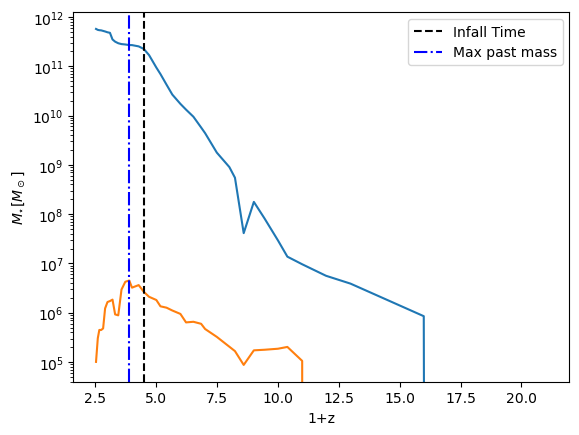

In [22]:
infall_idx,past_mass_idx,fp_mass,np_mass,fp_snaps,np_snaps = find_infall_and_maxpastmass(tree, fp_index=60, np_index=550160)

plt.plot(one_plus_z[fp_snaps], fp_mass * 10**10 / h)
plt.plot(one_plus_z[np_snaps], np_mass * 10**10 / h)
plt.axvline(x=one_plus_z[np_snaps[infall_idx]], color='black', linestyle='--', label='Infall Time')
plt.axvline(x=one_plus_z[np_snaps[past_mass_idx]], 
            color='blue', linestyle='-.', label='Max past mass')
plt.legend()
plt.yscale('log',base=10)
plt.xlabel('1+z')
plt.ylabel('$M_{\star}$[$M_\odot$]')

First mismatch at index 24: np=90664001, fp=90497323


Text(0, 0.5, '$M_{\\star}$[$M_\\odot$]')

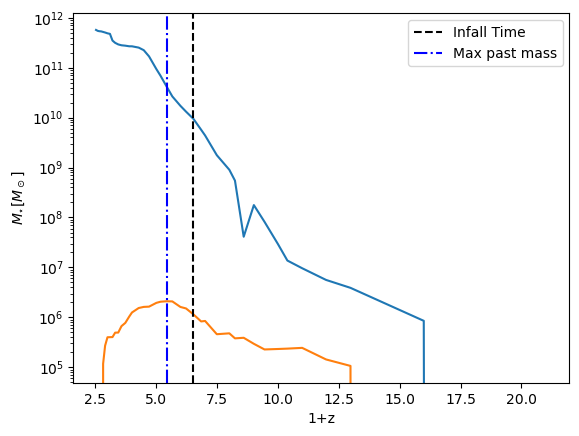

In [23]:
infall_idx,past_mass_idx,fp_mass,np_mass,fp_snaps,np_snaps = find_infall_and_maxpastmass(tree, fp_index=60, np_index=550367)

plt.plot(one_plus_z[fp_snaps], fp_mass * 10**10 / h)
plt.plot(one_plus_z[np_snaps], np_mass * 10**10 / h)
plt.axvline(x=one_plus_z[np_snaps[infall_idx]], color='black', linestyle='--', label='Infall Time')
plt.axvline(x=one_plus_z[np_snaps[past_mass_idx]], 
            color='blue', linestyle='-.', label='Max past mass')
plt.legend()
plt.yscale('log',base=10)
plt.xlabel('1+z')
plt.ylabel('$M_{\star}$[$M_\odot$]')

First mismatch at index 6: np=91047691, fp=90497305


Text(0, 0.5, '$M_{\\star}$[$M_\\odot$]')

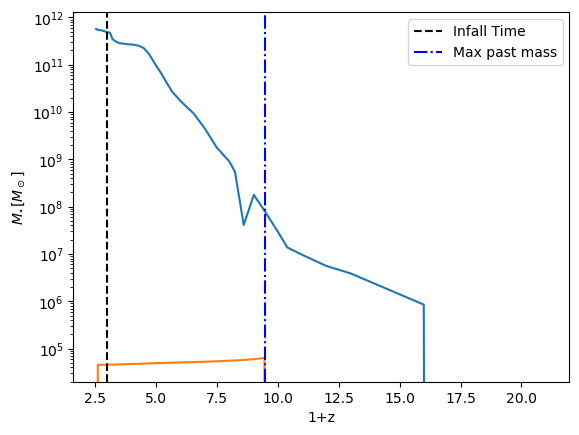

In [24]:
infall_idx,past_mass_idx,fp_mass,np_mass,fp_snaps,np_snaps = find_infall_and_maxpastmass(tree, fp_index=60, np_index=550446)

plt.plot(one_plus_z[fp_snaps], fp_mass * 10**10 / h)
plt.plot(one_plus_z[np_snaps], np_mass * 10**10 / h)
plt.axvline(x=one_plus_z[np_snaps[infall_idx]], color='black', linestyle='--', label='Infall Time')
plt.axvline(x=one_plus_z[np_snaps[past_mass_idx]], 
            color='blue', linestyle='-.', label='Max past mass')
plt.legend()
plt.yscale('log',base=10)
plt.xlabel('1+z')
plt.ylabel('$M_{\star}$[$M_\odot$]')

First mismatch at index 24: np=90664001, fp=90497323
First mismatch at index 16: np=94476762, fp=90497315


Text(0, 0.5, '$M_{\\star}$[$M_\\odot$]')

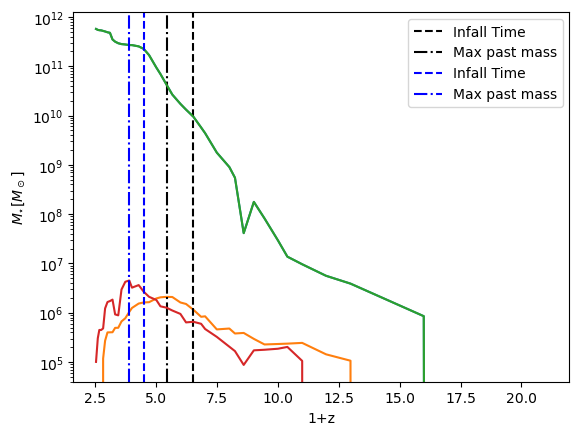

In [25]:
infall_idx,past_mass_idx,fp_mass,np_mass,fp_snaps,np_snaps = find_infall_and_maxpastmass(tree, fp_index=60, np_index=550367)

plt.plot(one_plus_z[fp_snaps], fp_mass * 10**10 / h)
plt.plot(one_plus_z[np_snaps], np_mass * 10**10 / h)
plt.axvline(x=one_plus_z[np_snaps[infall_idx]], color='black', linestyle='--', label='Infall Time')
plt.axvline(x=one_plus_z[np_snaps[past_mass_idx]], 
            color='black', linestyle='-.', label='Max past mass')

infall_idx,past_mass_idx,fp_mass,np_mass,fp_snaps,np_snaps = find_infall_and_maxpastmass(tree, fp_index=60, np_index=550160)

plt.plot(one_plus_z[fp_snaps], fp_mass * 10**10 / h)
plt.plot(one_plus_z[np_snaps], np_mass * 10**10 / h)
plt.axvline(x=one_plus_z[np_snaps[infall_idx]], color='blue', linestyle='--', label='Infall Time')
plt.axvline(x=one_plus_z[np_snaps[past_mass_idx]], 
            color='blue', linestyle='-.', label='Max past mass')

plt.legend()
plt.yscale('log',base=10)
plt.xlabel('1+z')
plt.ylabel('$M_{\star}$[$M_\odot$]')

In [35]:
Tree_MPB = il.sublink.loadTree(basePath,15,group_first_sub[0],fields=fields,onlyMPB=True)

In [74]:
Tree_MPB_False = il.sublink.loadTree(basePath,15,group_first_sub[0],fields=fields,onlyMPB=False)

Text(0, 0.5, '$M_{\\star}$[$M_\\odot$]')

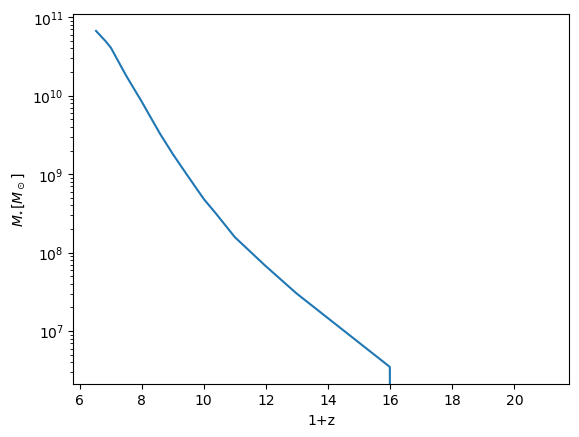

In [99]:
plt.plot(one_plus_z[Tree_MPB['SnapNum']],Tree_MPB['SubhaloMassType'][:,4]*10**10/h)
plt.yscale('log',base=10)
plt.xlabel('1+z')
plt.ylabel('$M_{\star}$[$M_\odot$]')

### Checking some mergers

In [13]:
sub_lentype = il.groupcat.loadSubhalos(basePath, snapNum=99, fields=['SubhaloLenType'])

In [14]:
Ngas = sub_lentype[:,0]
Ndm = sub_lentype[:,1]
Nstar = sub_lentype[:,4]
Nbh = sub_lentype[:,5]

idx = np.where((Ngas >= 100) & (Ndm >= 100) & (Nstar >= 100) & (Nbh >= 1))[0]

In [18]:
nselect = idx.size
print(nselect)

3734


In [21]:
ncheck = 10**np.int64(np.log10(nselect)-1)

In [29]:
for k,isub in enumerate(idx):
    tree = il.sublink.loadTree(basePath,99, isub, fields=fields, onlyMPB=False)
    if tree == None:
        print("tree is None")

In [30]:
tree

{'count': 1460,
 'SubhaloMass': array([1.2950426e+00, 1.2894481e+00, 1.2759441e+00, ..., 6.1473541e-04,
        6.1473541e-04, 6.1473541e-04], dtype=float32),
 'SubhaloSFRinRad': array([0.00035127, 0.00028072, 0.00038033, ..., 0.        , 0.        ,
        0.        ], dtype=float32)}